In [92]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torchvision.models as models

from d2l import torch as d2l

In [93]:
train_df = pd.read_csv(os.path.join('data', 'cifar-10', 'train.csv'))
train_df.head(10)

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile
5,6,automobile
6,7,bird
7,8,horse
8,9,ship
9,10,cat


In [94]:
# 各类别出现次数
train_df['label'].value_counts()

label
frog          5000
truck         5000
deer          5000
automobile    5000
bird          5000
horse         5000
ship          5000
cat           5000
dog           5000
airplane      5000
Name: count, dtype: int64

In [95]:
class_labels = train_df['label'].unique()
num_classes = len(class_labels)
num_classes

10

In [96]:
# 图像增广有助于解决过拟合的问题
transform_train = torchvision.transforms.Compose([
    # 在高度和宽度上将图像放大到40像素的正方形
    torchvision.transforms.Resize(40),
    # 随机裁剪出一个高度和宽度均为40像素的正方形图像，
    # 生成一个面积为原始图像面积0.64～1倍的小正方形，
    # 然后将其缩放为高度和宽度均为32像素的正方形
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                   ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    # 标准化每个通道
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

# 测试模式只对图像执行标准化，以消除评估结果中的随机性
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

In [97]:
batch_size = 64
valid_ratio = 0.1

In [98]:
all_dataset = torchvision.datasets.ImageFolder(
    os.path.join('data', 'cifar-10', 'images', 'train', 'reorg'),
    transform=None )

# 划分数据集为训练集和验证集  
total_len = len(all_dataset)  
val_len = int(valid_ratio * total_len)  
train_len = total_len - val_len  
train_dataset, val_dataset = random_split(
    all_dataset, 
    [train_len, val_len],
    # 如果需要可再现，使用固定的seed
    # generator=torch.Generator().manual_seed(42)
    )

train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_test

# 创建数据加载器  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [123]:
all_dataset[10]

(tensor([[[ 2.2233,  2.1845,  2.2233,  ...,  2.2233,  2.1845,  2.0101],
          [ 2.4365,  2.3590,  2.3202,  ...,  2.2233,  2.1652,  2.0295],
          [ 2.2039,  1.4867,  1.9713,  ...,  2.0295,  1.9325,  1.8356],
          ...,
          [ 0.4399,  0.7113,  0.9245,  ..., -2.0220, -2.0414, -2.0026],
          [ 0.5562,  0.6338,  0.6531,  ..., -1.9251, -1.9444, -1.9444],
          [ 0.4787,  0.3430,  0.1104,  ..., -1.7894, -1.8281, -1.8087]],
 
         [[ 2.3018,  2.2625,  2.3018,  ...,  2.3018,  2.2625,  2.0855],
          [ 2.5181,  2.4395,  2.4001,  ...,  2.3018,  2.2428,  2.1051],
          [ 2.2821,  1.5544,  2.0461,  ...,  2.1051,  2.0068,  1.9085],
          ...,
          [ 0.4924,  0.7678,  0.9841,  ..., -2.0053, -2.0249, -1.9856],
          [ 0.6104,  0.6891,  0.7088,  ..., -1.9069, -1.9266, -1.9266],
          [ 0.5318,  0.3941,  0.1581,  ..., -1.7692, -1.8086, -1.7889]],
 
         [[ 2.4611,  2.4221,  2.4611,  ...,  2.4611,  2.4221,  2.2465],
          [ 2.6757,  2.5976,

In [99]:
# 定义模型，加载预训练的weight
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# 获取模型最后一个全连接层（通常被称为fc层或分类层）的输入特征数量
num_ftrs = model.fc.in_features
# 替换全连接层
model.fc = nn.Linear(num_ftrs, num_classes)

loss = nn.CrossEntropyLoss(reduction="none")

In [100]:
lr = 2e-4
wd = 5e-4
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)

In [101]:
# 设置学习率调度器
# 每经过4个epoch, lr = lr*0.9
lr_period, lr_decay = 4, 0.9
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_period, lr_decay)

In [102]:
device = d2l.try_gpu()

In [103]:
from d2l import torch as d2l

def evaluate_model(model, data_loader):
    # 评估模式
    model.eval()
    # 累计预测正确数，总样本数
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            # 前向传播
            y_hat = model(X)
            metric.add(d2l.accuracy(y_hat, y), y.shape[0])
  
    # 返回正确率
    return metric[0]/metric[1]

def train_model(model, train_iter, valid_iter, num_epochs, device):
    # numbatches x batchsize = totalnumber
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend)
    model = model.to(device)
    for epoch in range(num_epochs):
        # 训练模式
        model.train()
        # 累计训练损失, 训练精度, 总样本数
        metric = d2l.Accumulator(3)
        # i取值0到numbatches
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X = X.to(device)
            y = y.to(device)
            # 预测值
            pred = model(X)
            # 损失
            l = loss(pred, y)
            l.sum().backward()
            optimizer.step()
            # 累计
            metric.add(l.sum(), d2l.accuracy(pred, y), y.shape[0])
            timer.stop()
            # 每5个批次更新plot，更新平均误差，正确的比率
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                train_loss = metric[0] / metric[2]
                train_acc = metric[1] / metric[2]
                animator.add( epoch + (i + 1) / num_batches, (train_loss, train_acc, None))
        # 每个epoch跑完进行验证
        if valid_iter is not None:
            valid_acc = evaluate_model(model, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))

        # 在每个epoch结束时更新学习率
        scheduler.step()
    

    measures = (f'train loss {metric[0]/metric[2]:.3f}, train acc {metric[1]/metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(device)}')

train loss 0.019, train acc 0.994, valid acc 0.833
5013.9 examples/sec on cuda:0


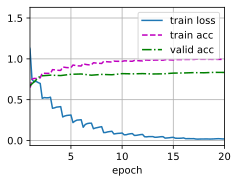

In [104]:
train_model(model, train_loader, val_loader, 20, device)

In [105]:
all_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [106]:
sorted_ids = list(range(1, 10))
sorted_ids.sort(key=lambda x: str(x))
sorted_ids

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [111]:
# 测试数据集
test_dataset = torchvision.datasets.ImageFolder(
    os.path.join('data', 'cifar-10', 'images', 'test'),
    transform=transform_test )
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# 预测
preds = []
for X, _ in test_loader:
    y_hat = model(X.to(device))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())




sorted_ids = list(range(1, len(test_dataset) + 1))
# ImageFolder读取数据是按文件名字典序
# 所以id也要按照字符串顺序才能对应
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
# 把idx转为实际的名称
df['label'] = df['label'].apply(lambda x: all_dataset.classes[x])
df.to_csv(os.path.join('submission', 'cifar-10-temp.csv'), index=False)


In [113]:
test_dataset.imgs

[('data\\cifar-10\\images\\test\\temp\\unknown\\5.png', 0),
 ('data\\cifar-10\\images\\test\\temp\\unknown\\7.png', 0)]